In [142]:
import numpy as np
import sympy, scipy, cmath
from sympy import *
#from sympy import symbols
#from sympy.solvers.solveset import nonlinsolve
from scipy import sparse as sp
#from scipy import linalg as ln
from scipy import optimize as opt
from scipy.sparse import  coo_matrix as cmm
from matplotlib import pyplot as pp

In [169]:
#Parameters
#global kx,mu, m, t, alR, B, kF, a, al, delta, phi, delL, delR, nu0, tL, tR, NJ, eye2, s1, s2, s3, tP, tM, t3

kx=0.

mu=1.8 #attention keep float
m=.5
t=1
alR=0.
def mut(kx):
    return mu-2*t-kx**2/(2*m)-alR**2*m/2
B=2     #looped
kF=np.sqrt(2*m*mu)

a=1/np.sqrt(2*m*t)
al=alR/a

delta=.5
phi=np.pi-0.0001    #looped
def delL(phi):
    return delta*cmath.exp(1j*phi/2)
def delR(phi):
    return delta*cmath.exp(-1j*phi/2)
nu0=m/(2*np.pi)
def xiE(En):
    return kF/(m*cmath.sqrt(delta**2-En**2))

tL=2
tR=tL
#def TT(B):
#    return -mut(0)+np.sqrt(t**2+B**2)

GammaL=np.pi*nu0*tL**2 #=m*tL**2/2
GammaR=np.pi*nu0*tR**2 #=m*tR**2/2

NJ=3

ET=np.pi/2*kF/m/(NJ*a)

print(GammaL,delta,ET)

#matrix tools
eye2=np.eye(2)
eye4=np.eye(4)
s1=[[0,1],[1,0]]
s2=[[0,-1j],[1j,0]]
s3=[[1,0],[0,-1]]
tP=np.kron([[0,1],[0,0]],eye2)
tM=np.kron([[0,0],[1,0]],eye2)
t3=np.kron(s3,eye2)

(1.0, 0.5, 1.4049629462081452)


In [170]:
#Junction
def HJ0(kx):
    return -mut(kx)*t3+alR*kx*np.kron(s3,s2)+B*np.kron(eye2,s1)
Hy=-t*t3+1j*al/2*np.kron(s3,s1)


def HJ(kx):
    start=cmm(HJ0(kx))
    HJs=start
    for n in range(2,NJ+1):
        OT=cmm(np.zeros([len(HJs.toarray())-4,4]))
        BT=sp.vstack([OT,cmm(Hy)])
        CT=sp.hstack([OT.transpose(),cmm(Hy.conj().T),start])
        HJs=sp.hstack([HJs,BT])
        HJs=sp.vstack([HJs,CT])
    return HJs

def gJm1(En,kx):
    return En*np.eye(4*NJ)-HJ(kx).toarray()

#Superconductors
# xiE-> infty to avoid more symbolic:
#def fL(kx):
#    return 1/(kF*a)*(np.log(1-np.exp(1j*a*(kF+kx)))+np.log(1-np.exp(1j*a*(kF-kx))))-1j

def fL(En,kx):
    return 1/(kF*a)*(cmath.log(1-cmath.exp(-a/xiE(En)+1j*a*(kF+kx)))+cmath.log(1-cmath.exp(-a/xiE(En)+1j*a*(kF-kx))))-1j

def gSC1m1(En,kx,phi):
    return 1/(np.pi*nu0*abs(fL(En,kx))**2)*((En*eye4 - delL(phi)*tP - np.conj(delL(phi))*tM)*\
                                                 fL(En,kx).imag/cmath.sqrt(delta**2 - En**2) - fL(En,kx).real*t3)

def gSC2m1(En,kx,phi):
    return 1/(np.pi*nu0*abs(fL(En,kx))**2)*((En*eye4 - delR(phi)*tP - np.conj(delR(phi))*tM)*\
                                                 fL(En,kx).imag/cmath.sqrt(delta**2 - En**2) - fL(En,kx).real*t3)

#SC/J coupling
rowindex=np.array([1,2,3,4,4*NJ+1,4*NJ+2,4*NJ+3,4*NJ+4])-1
colindex=np.array([5,6,7,8,4*(NJ+1)+1,4*(NJ+1)+2,4*(NJ+1)+3,4*(NJ+1)+4])-1
hoppings=[tL,tL,-tL,-tL,tR,tR,-tR,-tR]
mHt1=cmm((hoppings,(rowindex,colindex)),shape=(4*(NJ+2),4*(NJ+2)))
mHt=mHt1+mHt1.transpose()

#total inverse GF
def Gtotm1(En,kx,phi):
    return scipy.linalg.block_diag(gSC1m1(En,kx,phi),gJm1(En,kx),gSC2m1(En,kx,phi))+mHt.toarray()

In [171]:
M=50
Barray=np.linspace(0,5,M+1)
#Barray1=np.ndarray.tolist(np.linspace(3.2,3.https://www.youtube.com/?hl=FR3,20))
#Barray2=np.ndarray.tolist(np.linspace(9.15,9.45,40))
#Barray3=np.ndarray.tolist(np.linspace(2.9,3.1,30))
#Barray=[1]#np.asarray(Barray1+Barray2)#+Barray3)
#M=len(Barray)-1

PDphi=np.zeros((M+1,4))

En=0
zerogap=0.0000001

for qq in range(M+1):
    B=Barray[qq]
    print(qq)
    ekxphi=[]
    def fdet(phi):
        return np.linalg.det(Gtotm1(En,kx,phi))/(mu**(4*NJ))
    x0roots=np.ndarray.tolist(np.linspace(0,np.pi,6))
    for i in range(len(x0roots)):
        x0=x0roots[i]
        solekx=opt.fsolve(fdet,np.asarray(x0))
        if abs(fdet(solekx))>zerogap or solekx>2*np.pi+0.1 or solekx<0:
            solekx=[]
        solekx=np.ndarray.tolist(np.around(solekx,4))
        ekxphi.extend(solekx)
    ekxphi=list(set(ekxphi))
    print(ekxphi)
    if len(ekxphi)<4:
        zerocompletion=[0]*(4-len(ekxphi))
        ekxphi.extend(zerocompletion)
    elif len(ekxphi)>4:
        print("Too many roots.")
        break
    PDphi[qq]=np.asarray(ekxphi)

0
[]
1
[]
2
[2.7012, 3.582]
3
[2.3091]
4
[1.9397]
5
[1.5495]
6
[1.0946]
7
[0.3655]
8
[]
9
[]
10
[]
11
[]
12
[]
13
[]
14
[]
15
[]
16
[]
17
[]
18
[]
19
[]
20
[]
21
[]
22
[0.6747]
23
[1.4534]
24
[2.0526]
25
[2.6371]
26
[]
27
[2.4308]
28
[1.5277]
29
[]
30
[]
31
[]
32
[]
33
[]
34
[]
35
[]
36
[]
37
[]
38
[]
39
[]
40
[]
41
[]
42
[]
43
[]
44
[]
45
[]
46
[]
47
[]
48
[]
49
[]
50
[]


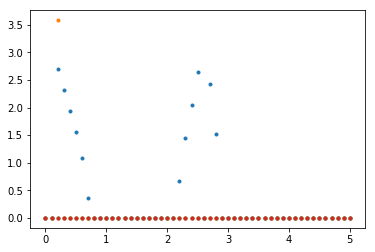

In [172]:
for p in range(len(PDphi[0])):
    pp.plot(Barray,PDphi[:,p],'.')
#pp.plot(3.26,np.pi,'*')
#pp.plot(9.26,np.pi,'*')
#pp.axis([3.1,3.5,2.5,3.7])

In [166]:
75*0.01+1.25

9.875

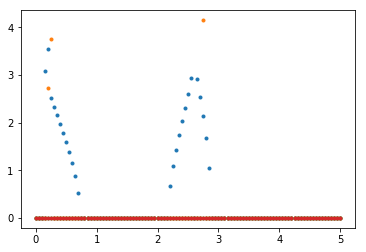

In [154]:
for p in range(len(PDphi[0])):
    pp.plot(Barray,PDphi[:,p],'.')
#pp.plot(3.26,np.pi,'*')
#pp.plot(9.26,np.pi,'*')
#pp.axis([3.1,3.5,2.5,3.7])

In [148]:
Barray

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ])

In [127]:
B=2.00585
ppk=np.arange(1000)*2*np.pi/1000
detppk=[np.linalg.det(Gtotm1(0,0,ppk[j]))/(mu**(4*(NJ+0))) for j in range(len(ppk))]
ppk[np.argmin(detppk)]

5.548052626239574

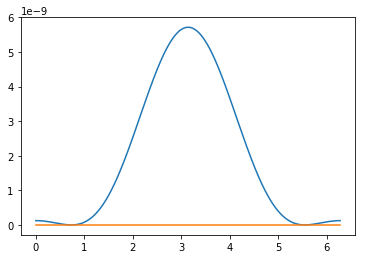

In [120]:
pp.plot(ppk,detppk)
pp.plot(ppk,np.zeros(len(ppk)))
#pp.axis([0,2*np.pi,0,10**-11])

In [129]:
uhgf=ppk[np.argmin(detppk)]
zer=(-uhgf)%(2*np.pi)

In [130]:
print(uhgf,zer)

(5.548052626239574, 0.735132680940012)
